In [1]:
import pandas as pd
import sys
import os
from sentence_transformers import SentenceTransformer
import umap
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz

In [2]:
df = pd.read_csv('~/Documents/papers/iass-mcc-twitter-colab/data/all_tweets.csv',lineterminator='\n')
df = df[~df.text.str.match('^RT @')]
print(df.shape)
df.head()

(2527419, 4)


id                 created_at  \
0  847762872910450688  2017-03-31 10:49:54+00:00   
1  836574925620137984  2017-02-28 13:52:59+00:00   
2  836909877062742016  2017-03-01 12:03:58+00:00   
3  836942635650646019  2017-03-01 14:14:08+00:00   
4  837615430508380160  2017-03-03 10:47:35+00:00   

                                                text           author_id  
0  Ich fürchte die Größenverhältnisse der Einnahm...  836553428042141697  
1  Langsam spricht es sich rum: Zuviel Dünger&amp...  836553428042141697  
2  Wir SPDler aus dem Bundestag und die BayernSPD...  836553428042141697  
3  @MartinSchulz positioniert sich zur Landwirtsc...  836553428042141697  
4  #Flächenfraß &amp; #Steuergeldverschwendung: B...  836553428042141697

In [3]:
author_df = pd.read_csv('~/Documents/papers/iass-mcc-twitter-colab/data/all_parliamentarians.csv').rename(columns={"id":"author_id"})
print(author_df.shape)
author_df.head()

(2368, 15)


Nachname         Vorname                       Fraktion    Twitter-Name  \
0      Ahrens          Sandra                            CDU   @sandraAhrens   
1      Aulepp  Sascha Karolin                            SPD             NaN   
2  Averwerser          Yvonne                            CDU    @Yaverwerser   
3        Beck           Peter  Liberal-Konservative Reformer             NaN   
4      Bensch          Rainer                            CDU   @BenschRainer   

   region Name, Vorname Vorname Nachname        handle   party parltype  \
0  Bremen           NaN              NaN  sandraAhrens  CDUCSU     Land   
1  Bremen           NaN              NaN           NaN     SPD     Land   
2  Bremen           NaN              NaN   Yaverwerser  CDUCSU     Land   
3  Bremen           NaN              NaN           NaN   other     Land   
4  Bremen           NaN              NaN  BenschRainer  CDUCSU     Land   

   author_id  person__id person__in_parlperiod seat_region_name   lcasehandle  
0        NaN         NaN                   NaN              NaN  sandraahrens  
1        NaN         NaN                   NaN              NaN           NaN  
2        NaN         NaN                   NaN              NaN   yaverwerser  
3        NaN         NaN                   NaN              NaN           NaN  
4        NaN         NaN                   NaN              NaN  benschrainer

In [4]:
df = df.merge(author_df[['author_id','region','party','parltype']],how="left")
print(df.shape)
df.head()

(2527419, 7)


id                 created_at  \
0  847762872910450688  2017-03-31 10:49:54+00:00   
1  836574925620137984  2017-02-28 13:52:59+00:00   
2  836909877062742016  2017-03-01 12:03:58+00:00   
3  836942635650646019  2017-03-01 14:14:08+00:00   
4  837615430508380160  2017-03-03 10:47:35+00:00   

                                                text           author_id  \
0  Ich fürchte die Größenverhältnisse der Einnahm...  836553428042141697   
1  Langsam spricht es sich rum: Zuviel Dünger&amp...  836553428042141697   
2  Wir SPDler aus dem Bundestag und die BayernSPD...  836553428042141697   
3  @MartinSchulz positioniert sich zur Landwirtsc...  836553428042141697   
4  #Flächenfraß &amp; #Steuergeldverschwendung: B...  836553428042141697   

  region party parltype  
0    NaN   NaN      NaN  
1    NaN   NaN      NaN  
2    NaN   NaN      NaN  
3    NaN   NaN      NaN  
4    NaN   NaN      NaN

In [5]:
df = df[pd.notna(df['party'])]
df = df[df['region']=="Bund"]
df['party'] = df['party'].str.upper()

df.shape

(1142371, 7)

In [6]:
df.created_at = pd.to_datetime(df['created_at'])
cutoff = datetime.datetime(2021,1,1,tzinfo=pytz.UTC)
cutoff2 = datetime.datetime(2021,9,20,tzinfo=pytz.UTC)

df = df[(df['created_at']>cutoff) & (df['created_at']<cutoff2)]
df = df.sort_values('created_at')
df = df.set_index('created_at')
print(df.shape)
df.tail()

(167337, 6)


id  \
created_at                                       
2021-09-19 22:55:52+00:00  1439724955265024002   
2021-09-19 23:01:38+00:00  1439726407295410183   
2021-09-19 23:11:45+00:00  1439728950218010625   
2021-09-19 23:12:45+00:00  1439729201159057411   
2021-09-19 23:26:35+00:00  1439732683324657665   

                                                                        text  \
created_at                                                                     
2021-09-19 22:55:52+00:00  Manchmal lohnt es sich ältere Gastbeiträge ern...   
2021-09-19 23:01:38+00:00  @axelgns @OlafScholz Nein, es sind 10 Mio Arbe...   
2021-09-19 23:11:45+00:00  Ich freue mich auf dieses Buch. @DirkBrockmann...   
2021-09-19 23:12:45+00:00  @schaefer_berlin Das Kohleausstiegsgesetz ist ...   
2021-09-19 23:26:35+00:00  Das hat nochmal negativ überrascht. Diesel nac...   

                            author_id region  party parltype  
created_at                                                    
2021-09-19 22:55:52+00:00    14784765   Bund  LINKE     Bund  
2021-09-19 23:01:38+00:00    15943222   Bund    SPD     Bund  
2021-09-19 23:11:45+00:00  3292982985   Bund    SPD     Bund  
2021-09-19 23:12:45+00:00  1423622834   Bund    SPD     Bund  
2021-09-19 23:26:35+00:00  3292982985   Bund    SPD     Bund

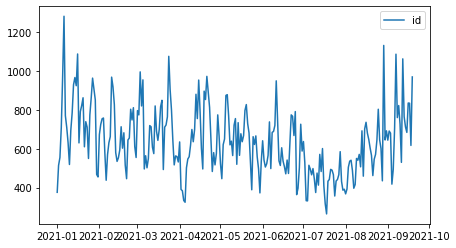

In [7]:
fig, ax = plt.subplots(figsize=(7,4))
counts = df.groupby(df.index.date)['id'].count().astype(int).to_frame()
counts.plot(ax=ax)

In [8]:
redo = True

if redo:

    import spacy
    nlp = spacy.load('de_core_news_sm')

    def lemmatize(doc):
        doc = nlp(doc)
        result = ' '.join([x.lemma_ for x in doc if not x.is_stop and not x.lemma_=="der"]) 
        return result

    df['clean_text'] = df.text.str.replace("(?:\@|https?\://)\S+", "").str.strip()
    df['clean_text'] = df.clean_text.str.replace("&amp;","")
    df['clean_text'] = df['clean_text'].apply(lemmatize)
    
    df.to_csv('source_data/lemmatized_tweets.csv',index=False)
    
else:
    
    df = pd.read_csv('source_data/lemmatized_tweets.csv',lineterminator='\n').dropna()
    
df.head()

id  \
created_at                                       
2021-01-01 00:00:56+00:00  1344795706700259329   
2021-01-01 00:02:04+00:00  1344795991002771456   
2021-01-01 00:03:28+00:00  1344796343877984256   
2021-01-01 00:07:06+00:00  1344797261461676033   
2021-01-01 00:08:39+00:00  1344797648688132096   

                                                                        text  \
created_at                                                                     
2021-01-01 00:00:56+00:00                  @kreischer_d @cducsubt Uğur Şahin   
2021-01-01 00:02:04+00:00              @mueller_sepp https://t.co/QkqccNfRg7   
2021-01-01 00:03:28+00:00  Alles Gute im neuen Jahr! Es kann nur besser w...   
2021-01-01 00:07:06+00:00  Einen guten Start ins neue Jahr. Wir haben vie...   
2021-01-01 00:08:39+00:00  Den Öko-Spießern, Klimahysterikern und #Covid-...   

                            author_id region   party parltype  \
created_at                                                      
2021-01-01 00:00:56+00:00    16361044   Bund  CDUCSU     Bund   
2021-01-01 00:02:04+00:00  2885729417   Bund  CDUCSU     Bund   
2021-01-01 00:03:28+00:00  2306519694   Bund  GRUENE     Bund   
2021-01-01 00:07:06+00:00    74837812   Bund   LINKE     Bund   
2021-01-01 00:08:39+00:00  2545743991   Bund     AFD     Bund   

                                                                  clean_text  
created_at                                                                    
2021-01-01 00:00:56+00:00                                         Uğur Şahin  
2021-01-01 00:02:04+00:00                                                     
2021-01-01 00:03:28+00:00                    alle Gute Jahr ! ich . Auf ’s !  
2021-01-01 00:07:06+00:00                       einer gut Start Jahr . ich .  
2021-01-01 00:08:39+00:00  Öko-Spießern , Klimahysterikern # Covid-Panike...

In [9]:
# 5 What hashtags are most commonly used

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
regex = r'\B(?!#[0-9_]+\b)(#\w{2,30})\b'

sub_df = df.reset_index()

vec =  CountVectorizer(min_df=1, token_pattern=regex)
X = vec.fit_transform(sub_df.text)
features = vec.get_feature_names()

hashtags = pd.DataFrame()
hashtags['hashtag'] = features

hashtags['total'] = np.array(X.sum(axis=0)).ravel()   

for p in df.party.unique():
    print('\n',p,'\n')
    idx = sub_df[sub_df.party==p].index
    fcounts = np.array(X[idx,:].sum(axis=0)).ravel()   
    hashtags[p] = fcounts
    sorted_counts = np.argsort(fcounts)
    for x in sorted_counts[-10:]:
        print(fcounts[x],features[x])


 CDUCSU 

99 #untersuchungsausschuss
105 #berlin
111 #cdupt21
170 #wegenmorgen
182 #scholz
201 #spd
216 #corona
226 #cdu
243 #bundestag
263 #wirecard

 GRUENE 

214 #triell
215 #btw21
226 #corona
244 #afghanistan
245 #csu
270 #bundestag
281 #bonn
331 #cdu
408 #laschet
411 #klimaschutz

 LINKE 

181 #bundesregierung
196 #noafd
197 #cdurausausderregierung
239 #afghanistan
245 #laschet
274 #linke
333 #bundestag
405 #cdu
505 #corona
564 #wirecard

 AFD 

191 #deutschlandabernormal
198 #cdu
200 #wirholendasdirektmandat
210 #merkel
219 #thüringen
221 #corona
247 #berlin
268 #gera
286 #bundestag
1003 #afd

 SPD 

91 #klimaschutz
99 #csu
101 #lobbyland
103 #wirecard
133 #triell
163 #corona
165 #bundestag
212 #laschet
237 #cdu
295 #spd

 FDP 

90 #mpk
91 #mietendeckel
97 #berlin
118 #wirecard
121 #bundestag
123 #bundesregierung
125 #bpt21
175 #vielzutun
221 #fdp
291 #corona


In [10]:
# All hashtags
pd.options.display.max_rows = 999
hashtags.sort_values('total',ascending=False).head(500).to_csv('results/top_hashtags.csv',index=False)
hashtags.sort_values('total',ascending=False).head(10)

hashtag  total  CDUCSU  GRUENE  LINKE   AFD  SPD  FDP
2747        #corona   1622     216     226    505   221  163  291
2491           #cdu   1486     226     331    405   198  237   89
2215     #bundestag   1418     243     270    333   286  165  121
16323     #wirecard   1235     263     156    564    31  103  118
241            #afd   1192      46      27     26  1003   56   34
8651       #laschet   1044      59     408    245    70  212   50
13613          #spd    918     201     162    104    86  295   70
272    #afghanistan    754      82     244    239    52   78   59
1477        #berlin    690     105      93     82   247   66   97
8015   #klimaschutz    684      52     411     90     8   91   32

In [11]:
# 5 What hashtags are most commonly used

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
regex = r'\b(?<!#)(\w{2,30})\b'

sub_df = df.reset_index()

vec =  TfidfVectorizer(min_df=1, token_pattern=regex,sublinear_tf=True)
vec =  CountVectorizer(min_df=1, token_pattern=regex)
term_X = vec.fit_transform(sub_df.clean_text)
term_features = vec.get_feature_names()

terms = pd.DataFrame()
terms['hashtag'] = term_features

terms['total'] = np.array(term_X.sum(axis=0)).ravel()   

for p in df.party.unique():
    print('\n',p,'\n')
    idx = sub_df[sub_df.party==p].index
    fcounts = np.array(term_X[idx,:].sum(axis=0)).ravel()   
    terms[p] = fcounts
    sorted_counts = np.argsort(fcounts)
    for x in sorted_counts[-10:]:
        print(fcounts[x],term_features[x])


 CDUCSU 

464 in
524 mit
531 jahr
560 cdu
623 mal
640 und
686 danken
699 heute
1152 mein
5417 ich

 GRUENE 

671 mal
731 klimaschutz
750 mensch
781 cdu
802 brauchen
841 danken
1012 jahr
1078 und
1127 mein
5721 ich

 LINKE 

792 corona
816 cdu
855 in
985 mal
1021 aber
1026 mensch
1029 jahr
1054 und
1407 mein
7654 ich

 AFD 

411 was
433 wenn
436 bundestag
465 deutschland
501 jahr
514 mal
566 und
691 mein
1388 afd
3184 ich

 SPD 

599 danken
628 aber
668 sein
669 in
789 spd
851 jahr
885 mal
1087 mein
1105 und
6264 ich

 FDP 

639 und
647 mal
648 jahr
654 wenn
714 corona
899 fdp
915 danken
946 mein
1869 tb
6109 ich


In [12]:
terms.sort_values('total',ascending=False).head(500).to_csv('results/top_terms.csv',index=False)
terms.sort_values('total',ascending=False).head(10)

hashtag  total  CDUCSU  GRUENE  LINKE   AFD   SPD   FDP
41133     ich  34349    5417    5721   7654  3184  6264  6109
55957    mein   6410    1152    1127   1407   691  1087   946
86704     und   5082     640    1078   1054   566  1105   639
44158    jahr   4572     531    1012   1029   501   851   648
54562     mal   4325     623     671    985   514   885   647
17935  danken   3746     686     841    544   161   599   915
56188  mensch   3548     395     750   1026   258   567   552
42114      in   3478     464     636    855   345   669   509
1602     aber   3404     380     523   1021   292   628   560
16128     cdu   3386     560     781    816   380   554   295

In [13]:
# 5 What hashtags are most commonly used

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
regex = r'\b(?<!#)(\w{2,30})\b'

sub_df = df.reset_index()

vec =  TfidfVectorizer(min_df=1, token_pattern=regex,sublinear_tf=True)
vec =  CountVectorizer(min_df=1, token_pattern=regex, ngram_range=(2,2))
bigram_X = vec.fit_transform(sub_df.clean_text)
bigram_features = vec.get_feature_names()

bigrams = pd.DataFrame()
bigrams['hashtag'] = bigram_features

bigrams['total'] = np.array(bigram_X.sum(axis=0)).ravel()   

for p in df.party.unique():
    print('\n',p,'\n')
    idx = sub_df[sub_df.party==p].index
    fcounts = np.array(bigram_X[idx,:].sum(axis=0)).ravel()   
    bigrams[p] = fcounts
    sorted_counts = np.argsort(fcounts)
    for x in sorted_counts[-10:]:
        print(fcounts[x],bigram_features[x])


 CDUCSU 

69 untersuchungsausschuss wirecard
73 ich wünsche
76 mindestens impfen
82 ich mal
88 ich finden
119 viel dank
139 olaf scholz
141 ich freuen
143 ich brauchen
242 herzliche glückwunsch

 GRUENE 

90 robert habeck
91 ich finden
94 alle gute
100 olaf scholz
103 viel dank
123 csu spd
199 ich freuen
299 cdu csu
302 herzliche glückwunsch
325 ich brauchen

 LINKE 

86 ich mal
92 ich glauben
93 de masi
111 corona krise
121 ich freuen
121 herzliche glückwunsch
162 cdu csu
178 die linke
182 ich finden
227 ich brauchen

 AFD 

78 deutschlandabernormal wirholendasdirektmandat
82 altenburgerland wk194
82 wirholendasdirektmandat gera
84 wk194 berlin
92 greiz altenburgerland
97 thüringen deutschlandabernormal
132 gera greiz
146 bundestag brandner
148 afd thüringen
154 berlin bundestag

 SPD 

72 ich mal
73 armin laschet
86 olaf scholz
95 buongiorno franke
106 viel dank
111 ich finden
119 cdu csu
133 ich brauchen
138 ich freuen
297 herzliche glückwunsch

 FDP 

84 danken meinung
85 danken s

In [14]:
bigrams.sort_values('total',ascending=False).head(500).to_csv('results/top_bigrams.csv',index=False)
bigrams.sort_values('total',ascending=False).head(50)

hashtag  total  CDUCSU  GRUENE  LINKE  AFD  SPD  FDP
284208  herzliche glückwunsch   1153     242     302    121   31  297  160
297872           ich brauchen   1086     143     325    227   35  133  223
299020             ich freuen    752     141     199    121   34  138  119
116812                cdu csu    739      44     299    162   45  119   70
652666              viel dank    637     119     103     84   56  106  169
298899             ich finden    564      88      91    182   26  111   66
464326            olaf scholz    438     139     100     60   11   86   42
300728                ich mal    420      82      53     86   51   72   76
384000             letzt jahr    309      38      80     65   32   43   51
299388            ich glauben    306      32      40     92   32   53   57
46802           armin laschet    293      58      90     34   13   73   25
303874            ich wünsche    278      73      49     57   22   55   22
284915            heute abend    277      39      76     60   15   32   55
300801               ich mein    271      51      38     46   46   40   50
63397       baden württemberg    266      24      46     33   11   35  117
298145             ich denken    259      49      42     72   16   45   35
712019           zum beispiel    251      45      58     37   21   51   39
26687               alle gute    243      33      94     27    4   63   22
302501             ich stehen    236      50      44     34   24   57   27
299759             ich hoffen    235      42      34     53   17   48   41
678816               wenn ich    227      29      28     47   48   35   40
123417           corona krise    225      16      28    111    7   20   43
123593        corona pandemie    224      41      49     49    5   36   44
299828                ich ich    221      45      20     33   35   46   42
302187              ich sehen    220      43      25     52   19   52   29
303663               ich weiß    216      38      31     60   23   42   22
298955            ich fordern    206      12      51     62   14   15   52
130347             danken ich    206      20      37     14    9   19  107
299546                ich hab    205      36      44     69    7   32   17
297822            ich bleiben    204      38      22     40   20   52   32
167183            einfach mal    203      46      23     44   22   37   31
4242                  20 jahr    203      24      48     60   27   28   16
520627         sachsen anhalt    202      30      25     27   36   41   43
91                     00 uhr    199      23      26     39   27   25   59
652705          viel erfolgen    199      41      46     44    5   36   27
8264                   30 uhr    195      34      54     40    8   31   28
303796             ich wissen    189      31      32     32   25   34   35
270089           guten morgen    188      33      51     21   20   44   19
130697            danken sich    187      18      38     18    0   28   85
298395            ich einfach    184      31      29     35   21   34   34
461718                 of the    183      28      25     37    2   68   23
130524            danken mein    183      45      44     27    6   40   21
300155             ich kennen    182      38      20     49   17   34   24
145141              die linke    181       1       0    178    2    0    0
142333     deutsche bundestag    177      51      29     17   24   30   26
272088              haben ich    175      29      19     32   23   32   40
284197         herzliche dank    175      62      38     17    3   24   31
2865                  16 jahr    174      12      84     33   18   11   16
422575           million euro    173      28      40     49   20   16   20
303345          ich verstehen    170      19      23     46   14   35   33

In [15]:
term_topics = pd.read_excel('data/woerter_und_hashtags_v3.xlsx')
term_topics.head()

hashtag           topic Unnamed: 2
0  bundestag  politik-intern        NaN
1     corona          corona        NaN
2        cdu        parteien        NaN
3     danken    zusammenhalt        NaN
4        afd        parteien        NaN

In [16]:
topics = []
for topic, group in term_topics.groupby('topic'):
    topics.append(topic)
    df[topic]=0
    cloc = df.columns.get_loc(topic)
    for term in group.hashtag.unique():
        term = str(term)
        if "#" in term:
            x = X
            feat = features
        else:
            x = term_X
            feat = term_features
            term_id = np.argwhere(np.array(feat)==term).ravel()
            idx = x[:,term_id].nonzero()[0] 
            df.iloc[idx,cloc] = 1

In [17]:
topic_ds = [
    {"name":"digitales","keywords":[
        "digital\w* *bildung",
        "digital\w* *verwaltung",
        "^(?=.*5g)(?!.*(impf|covid|pandemie|corona)).*",
        "automatisier(en|t|ung)",
        "digitale\w* *\w*ämt"
    ]},
    {"name":"verkehr","keywords": ["^(?=.*auto)(?!.*matisier).*",]},
    {"name": "arbeit", "keywords": ["beruf(?!en)"]},
    {"name": "außenpolitik", "keywords": ["vereint\w* *nationen","(?<!ent)rüstung"]},
    {"name": "familien", "keywords": ["^(?=.*familien)(?!.*(angehörige|opfer)).*"]},
    {"name": "wohnen", "keywords": ["bauen\W*bauen\W*bauen"]},
    {"name": "gewalt", "keywords": ["^(?=.*gewalt)(?!.*(vierte|dritte)).*"]}
]
topic_names = []
redo = True
for t in topic_ds:
    print(t)
    if t["name"] not in topics:
        topics.append(t["name"])
    for term in t["keywords"]:
        df.loc[df['text'].str.lower().str.contains(term.lower()),t["name"]] = 1

df.head()

{'name': 'digitales', 'keywords': ['digital\\w* *bildung', 'digital\\w* *verwaltung', '^(?=.*5g)(?!.*(impf|covid|pandemie|corona)).*', 'automatisier(en|t|ung)', 'digitale\\w* *\\w*ämt']}


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


{'name': 'verkehr', 'keywords': ['^(?=.*auto)(?!.*matisier).*']}
{'name': 'arbeit', 'keywords': ['beruf(?!en)']}
{'name': 'außenpolitik', 'keywords': ['vereint\\w* *nationen', '(?<!ent)rüstung']}
{'name': 'familien', 'keywords': ['^(?=.*familien)(?!.*(angehörige|opfer)).*']}
{'name': 'wohnen', 'keywords': ['bauen\\W*bauen\\W*bauen']}
{'name': 'gewalt', 'keywords': ['^(?=.*gewalt)(?!.*(vierte|dritte)).*']}


id  \
created_at                                       
2021-01-01 00:00:56+00:00  1344795706700259329   
2021-01-01 00:02:04+00:00  1344795991002771456   
2021-01-01 00:03:28+00:00  1344796343877984256   
2021-01-01 00:07:06+00:00  1344797261461676033   
2021-01-01 00:08:39+00:00  1344797648688132096   

                                                                        text  \
created_at                                                                     
2021-01-01 00:00:56+00:00                  @kreischer_d @cducsubt Uğur Şahin   
2021-01-01 00:02:04+00:00              @mueller_sepp https://t.co/QkqccNfRg7   
2021-01-01 00:03:28+00:00  Alles Gute im neuen Jahr! Es kann nur besser w...   
2021-01-01 00:07:06+00:00  Einen guten Start ins neue Jahr. Wir haben vie...   
2021-01-01 00:08:39+00:00  Den Öko-Spießern, Klimahysterikern und #Covid-...   

                            author_id region   party parltype  \
created_at                                                      
2021-01-01 00:00:56+00:00    16361044   Bund  CDUCSU     Bund   
2021-01-01 00:02:04+00:00  2885729417   Bund  CDUCSU     Bund   
2021-01-01 00:03:28+00:00  2306519694   Bund  GRUENE     Bund   
2021-01-01 00:07:06+00:00    74837812   Bund   LINKE     Bund   
2021-01-01 00:08:39+00:00  2545743991   Bund     AFD     Bund   

                                                                  clean_text  \
created_at                                                                     
2021-01-01 00:00:56+00:00                                         Uğur Şahin   
2021-01-01 00:02:04+00:00                                                      
2021-01-01 00:03:28+00:00                    alle Gute Jahr ! ich . Auf ’s !   
2021-01-01 00:07:06+00:00                       einer gut Start Jahr . ich .   
2021-01-01 00:08:39+00:00  Öko-Spießern , Klimahysterikern # Covid-Panike...   

                           0  ?  agrar  ...  sozialpolitik  staat  verkehr  \
created_at                              ...                                  
2021-01-01 00:00:56+00:00  0  0      0  ...              0      0        0   
2021-01-01 00:02:04+00:00  0  0      0  ...              0      0        0   
2021-01-01 00:03:28+00:00  0  0      0  ...              0      0        0   
2021-01-01 00:07:06+00:00  0  0      0  ...              0      0        0   
2021-01-01 00:08:39+00:00  0  0      0  ...              0      0        0   

                           wahlen  wirtschaft  wissenschaft  wohnen  zukunft  \
created_at                                                                     
2021-01-01 00:00:56+00:00       0           0             0       0        0   
2021-01-01 00:02:04+00:00       0           0             0       0        0   
2021-01-01 00:03:28+00:00       0           0             0       0        0   
2021-01-01 00:07:06+00:00       0           0             0       0        0   
2021-01-01 00:08:39+00:00       0           0             0       0        0   

                           zusammenhalt  familien  
created_at                                         
2021-01-01 00:00:56+00:00             0       NaN  
2021-01-01 00:02:04+00:00             0       NaN  
2021-01-01 00:03:28+00:00             0       NaN  
2021-01-01 00:07:06+00:00             0       NaN  
2021-01-01 00:08:39+00:00             0       NaN  

[5 rows x 51 columns]

In [18]:
df.to_csv('source_data/ht_term_annotated_tweets.csv',index=False)

In [19]:
cdict = {'afd': '#009EE0',
 'bp': None,
 'cducsu': '#000000',
 'dp': None,
 'drp': None,
 'dzp': None,
 'fdp': '#FFED00',
 'fraktionslos': None,
 'gb/bhe': None,
 'gruene': '#64A12D',
 'kpd': None,
 'linke': '#8C3473',
 'other': None,
 'parteilos': None,
 'pds': None,
 'spd': '#EB001F',
 'wav': None}

In [20]:
if type(df.index) == pd.core.indexes.numeric.Int64Index:
    df_times = pd.read_csv('~/Documents/papers/iass-mcc-twitter-colab/data/all_tweets.csv',lineterminator='\n')
    df_times['created_at'] = pd.to_datetime(df_times['created_at'])
    df = df.merge(df_times[['id','created_at']])
    df = df.set_index("created_at")
    
df.head()

id  \
created_at                                       
2021-01-01 00:00:56+00:00  1344795706700259329   
2021-01-01 00:02:04+00:00  1344795991002771456   
2021-01-01 00:03:28+00:00  1344796343877984256   
2021-01-01 00:07:06+00:00  1344797261461676033   
2021-01-01 00:08:39+00:00  1344797648688132096   

                                                                        text  \
created_at                                                                     
2021-01-01 00:00:56+00:00                  @kreischer_d @cducsubt Uğur Şahin   
2021-01-01 00:02:04+00:00              @mueller_sepp https://t.co/QkqccNfRg7   
2021-01-01 00:03:28+00:00  Alles Gute im neuen Jahr! Es kann nur besser w...   
2021-01-01 00:07:06+00:00  Einen guten Start ins neue Jahr. Wir haben vie...   
2021-01-01 00:08:39+00:00  Den Öko-Spießern, Klimahysterikern und #Covid-...   

                            author_id region   party parltype  \
created_at                                                      
2021-01-01 00:00:56+00:00    16361044   Bund  CDUCSU     Bund   
2021-01-01 00:02:04+00:00  2885729417   Bund  CDUCSU     Bund   
2021-01-01 00:03:28+00:00  2306519694   Bund  GRUENE     Bund   
2021-01-01 00:07:06+00:00    74837812   Bund   LINKE     Bund   
2021-01-01 00:08:39+00:00  2545743991   Bund     AFD     Bund   

                                                                  clean_text  \
created_at                                                                     
2021-01-01 00:00:56+00:00                                         Uğur Şahin   
2021-01-01 00:02:04+00:00                                                      
2021-01-01 00:03:28+00:00                    alle Gute Jahr ! ich . Auf ’s !   
2021-01-01 00:07:06+00:00                       einer gut Start Jahr . ich .   
2021-01-01 00:08:39+00:00  Öko-Spießern , Klimahysterikern # Covid-Panike...   

                           0  ?  agrar  ...  sozialpolitik  staat  verkehr  \
created_at                              ...                                  
2021-01-01 00:00:56+00:00  0  0      0  ...              0      0        0   
2021-01-01 00:02:04+00:00  0  0      0  ...              0      0        0   
2021-01-01 00:03:28+00:00  0  0      0  ...              0      0        0   
2021-01-01 00:07:06+00:00  0  0      0  ...              0      0        0   
2021-01-01 00:08:39+00:00  0  0      0  ...              0      0        0   

                           wahlen  wirtschaft  wissenschaft  wohnen  zukunft  \
created_at                                                                     
2021-01-01 00:00:56+00:00       0           0             0       0        0   
2021-01-01 00:02:04+00:00       0           0             0       0        0   
2021-01-01 00:03:28+00:00       0           0             0       0        0   
2021-01-01 00:07:06+00:00       0           0             0       0        0   
2021-01-01 00:08:39+00:00       0           0             0       0        0   

                           zusammenhalt  familien  
created_at                                         
2021-01-01 00:00:56+00:00             0       NaN  
2021-01-01 00:02:04+00:00             0       NaN  
2021-01-01 00:03:28+00:00             0       NaN  
2021-01-01 00:07:06+00:00             0       NaN  
2021-01-01 00:08:39+00:00             0       NaN  

[5 rows x 51 columns]

0
mentioned  8064  times


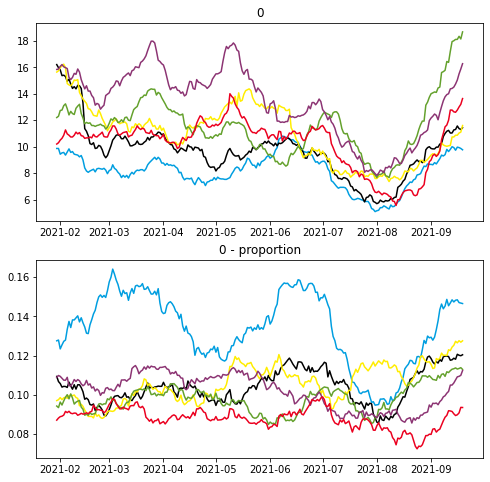

?
mentioned  8064  times


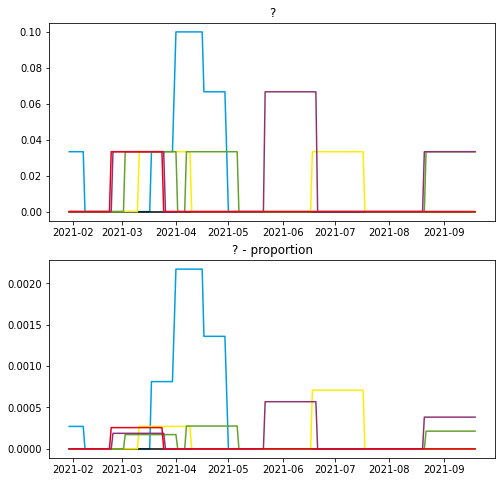

agrar
mentioned  8064  times


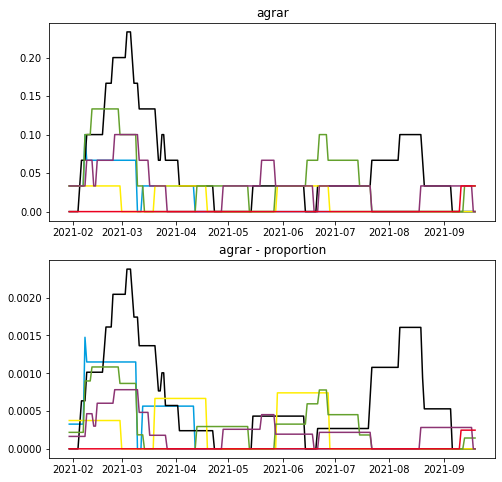

arbeit
mentioned  8064  times


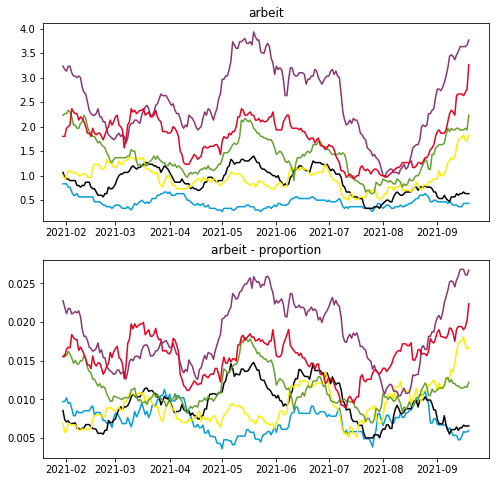

außenpolitik
mentioned  8064  times


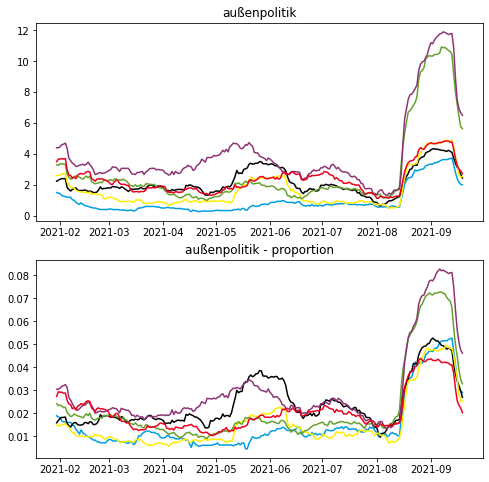

bildung
mentioned  8064  times


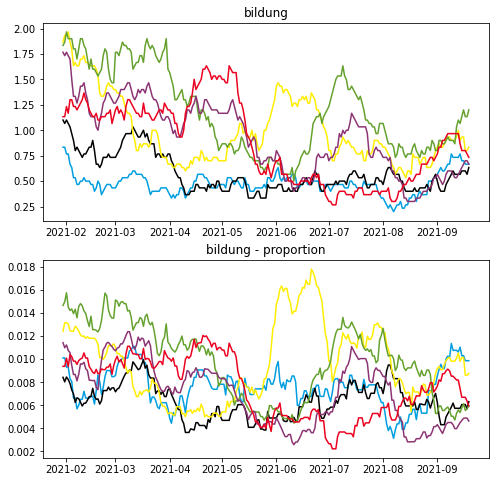

bürokratie
mentioned  8064  times


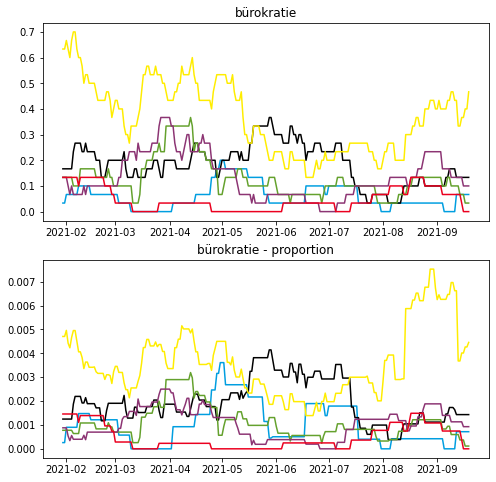

corona
mentioned  8064  times


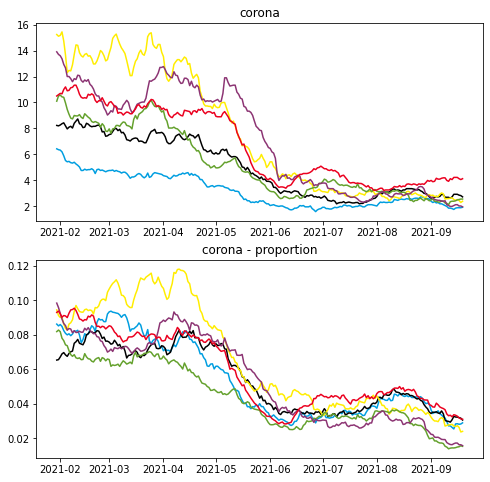

debatte
mentioned  8064  times


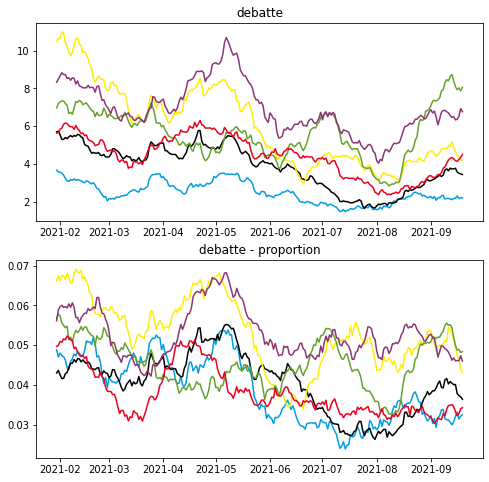

digitales
mentioned  8064  times


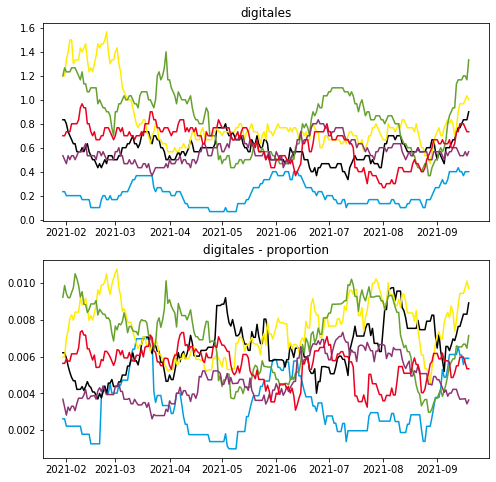

diskriminierung
mentioned  8064  times


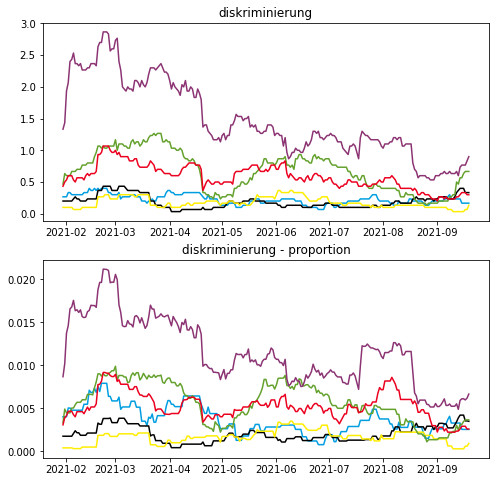

einfamilienhaus
mentioned  8064  times


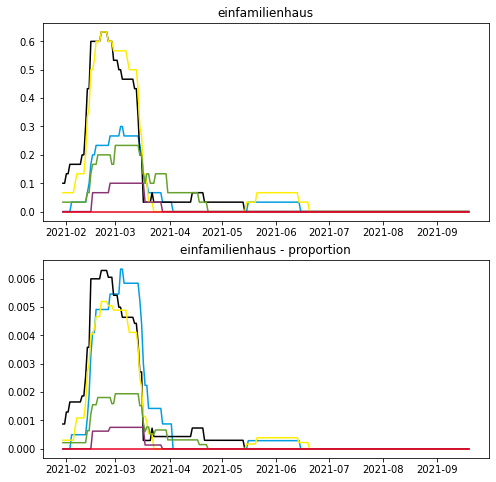

emotion
mentioned  8064  times


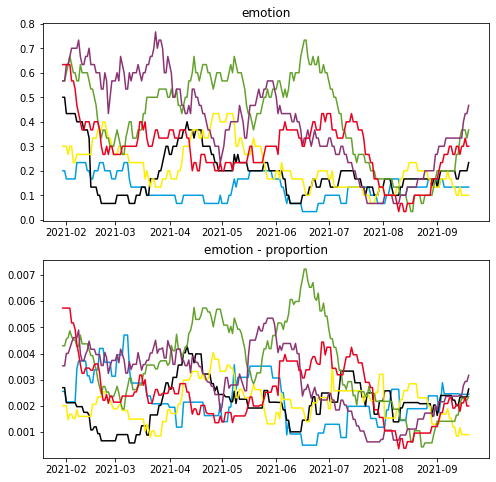

engagement
mentioned  8064  times


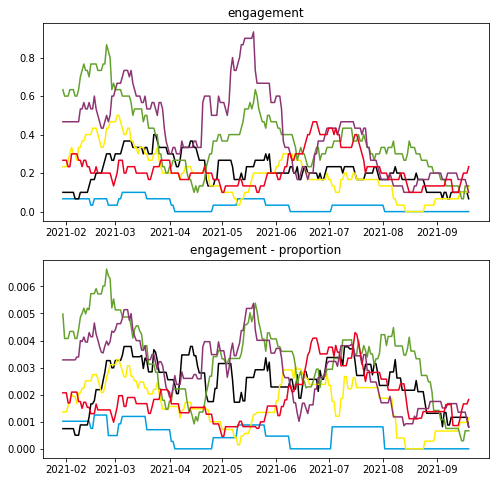

erinnerung
mentioned  8064  times


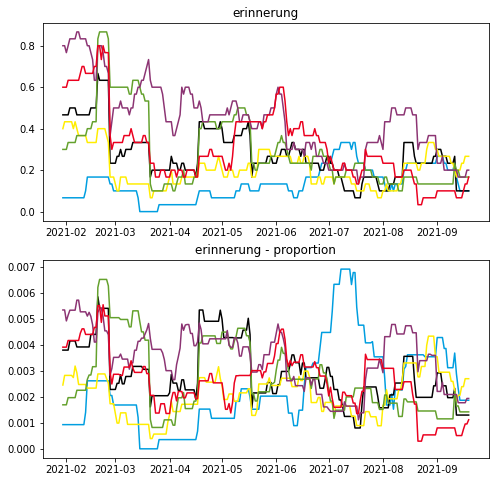

europa
mentioned  8064  times


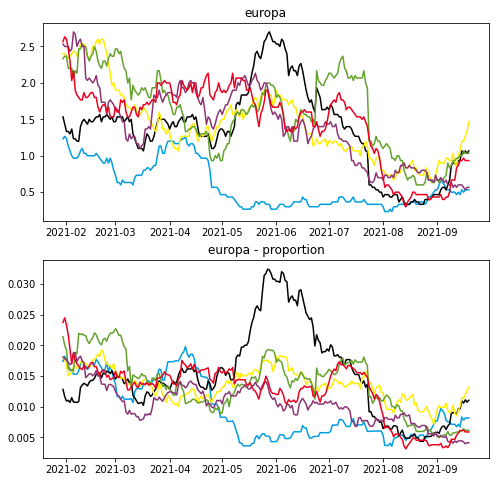

familie
mentioned  8064  times


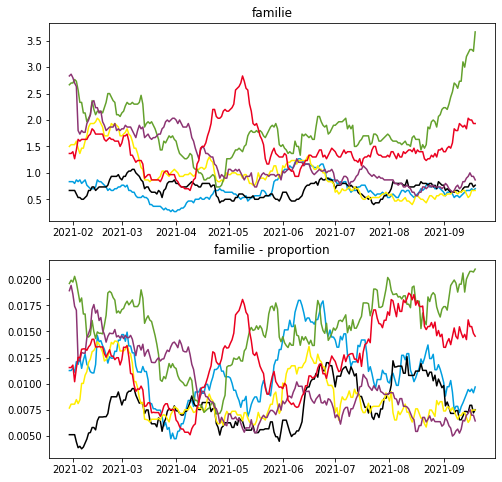

freiheit
mentioned  8064  times


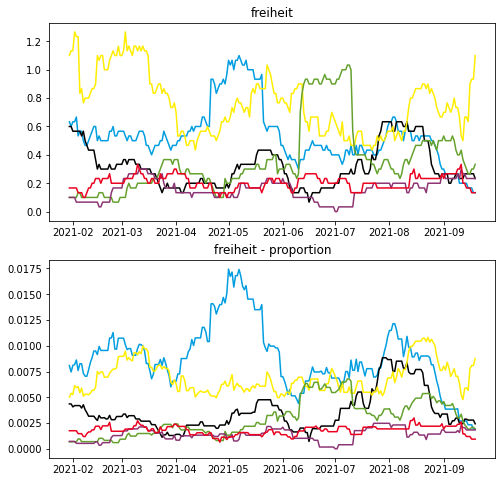

gesellschaft
mentioned  8064  times


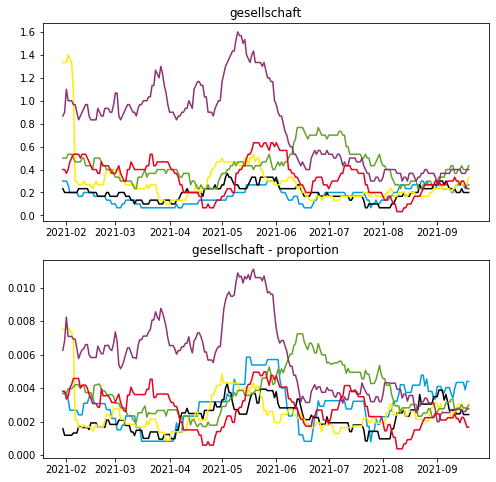

gewalt
mentioned  8064  times


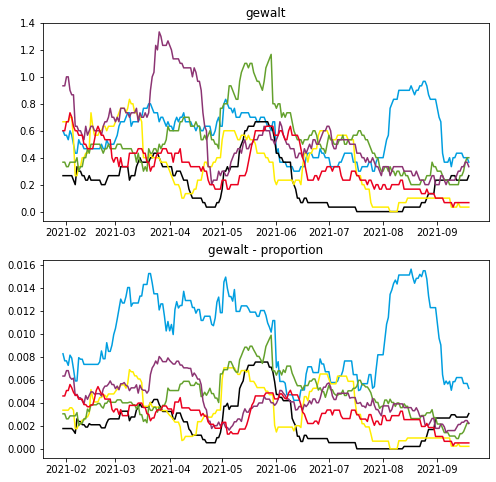

gleichberechtigung
mentioned  8064  times


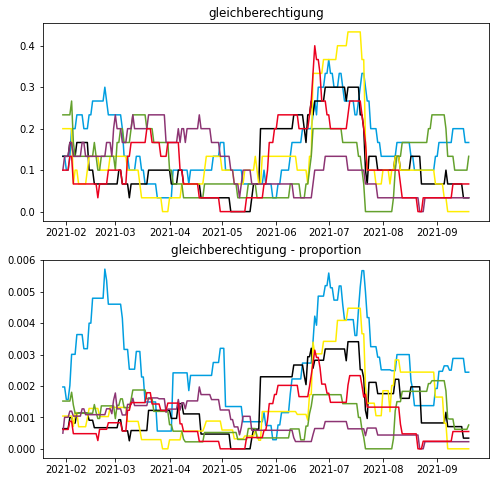

internationales
mentioned  8064  times


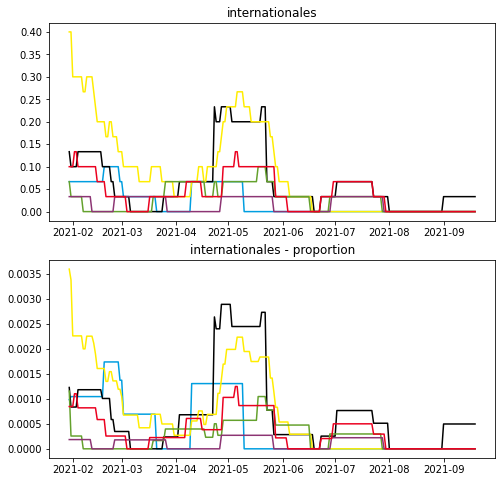

klima
mentioned  8064  times


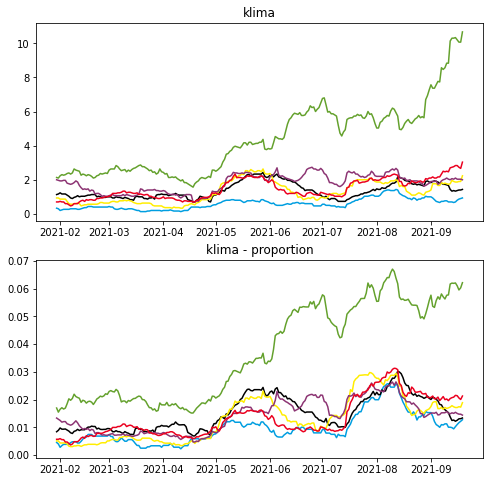

korruption
mentioned  8064  times


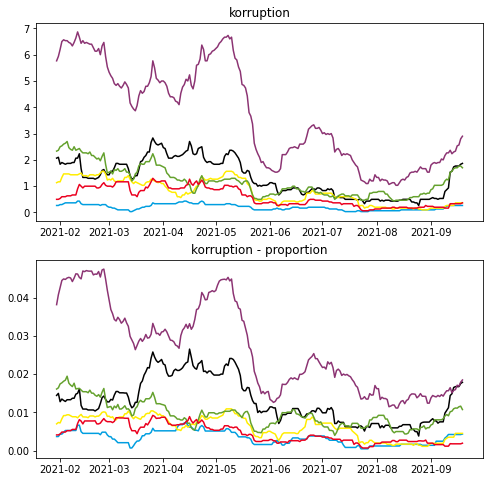

medien
mentioned  8064  times


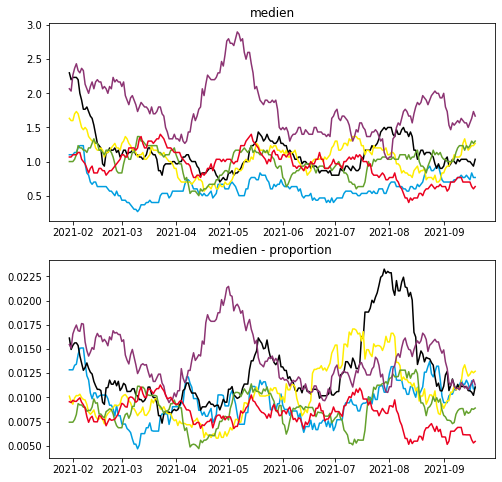

menschenrechte
mentioned  8064  times


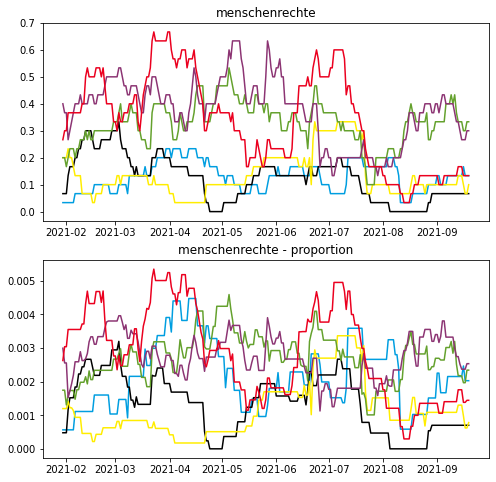

migration
mentioned  8064  times


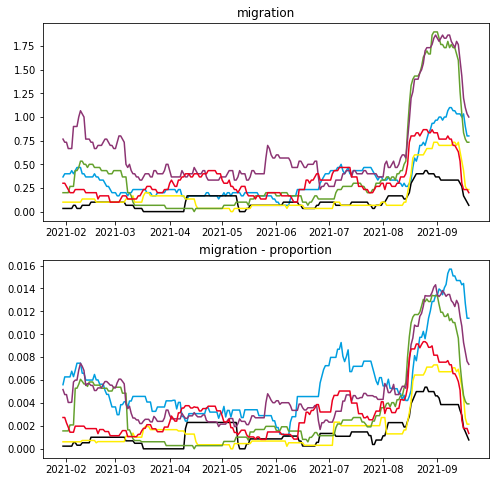

parteien
mentioned  8064  times


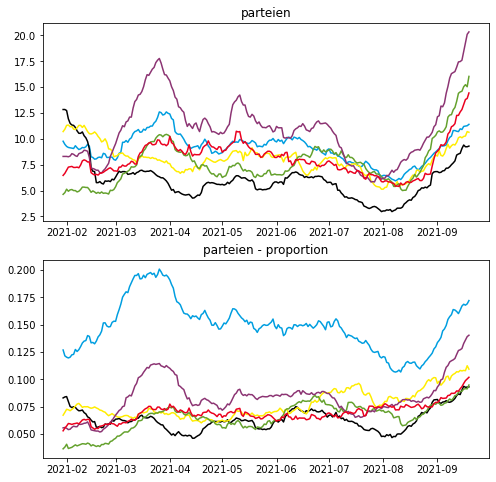

politik-intern
mentioned  8064  times


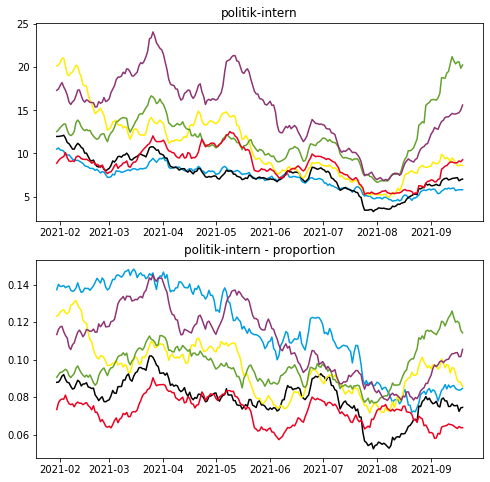

politiker
mentioned  8064  times


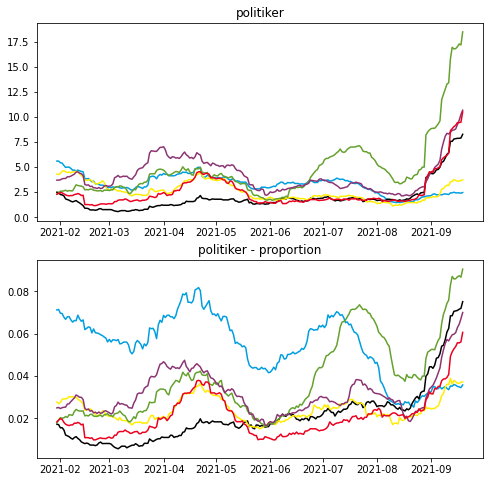

recht
mentioned  8064  times


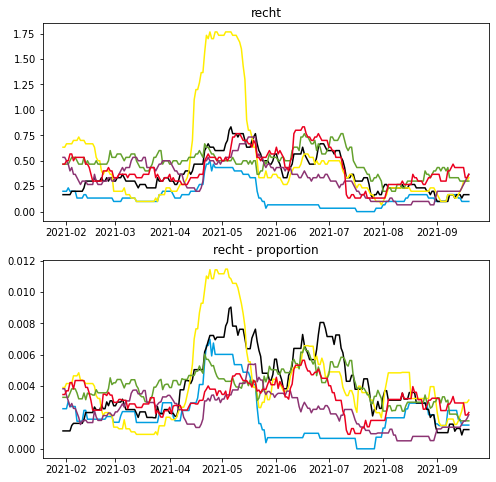

religion
mentioned  8064  times


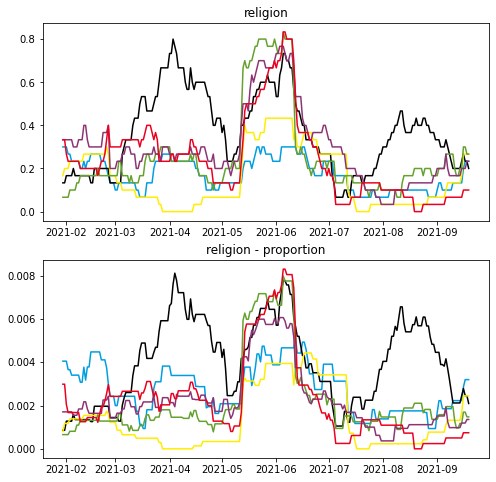

rente
mentioned  8064  times


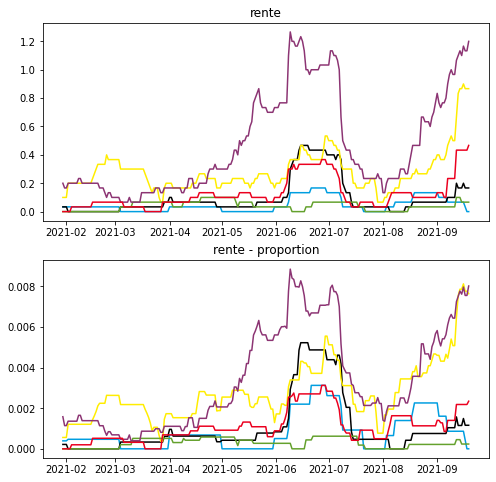

sicherheit
mentioned  8064  times


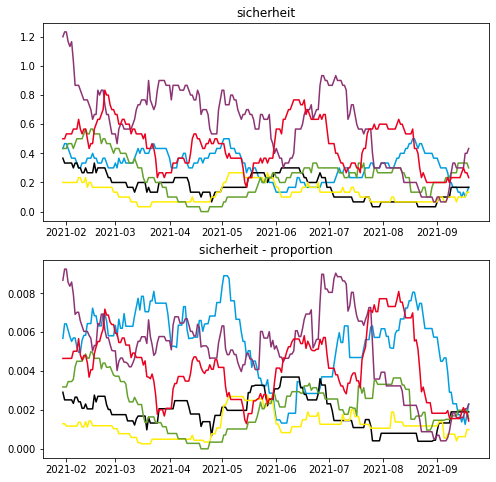

sozialpolitik
mentioned  8064  times


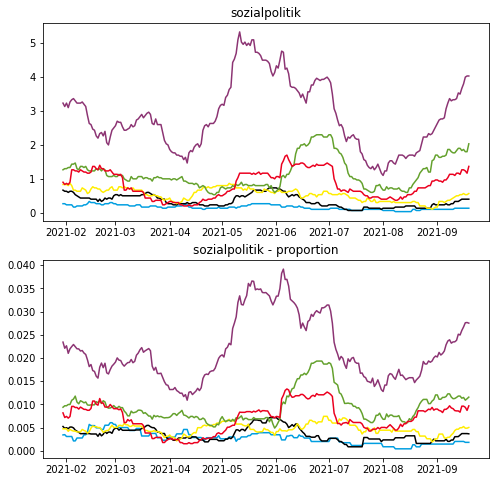

staat
mentioned  8064  times


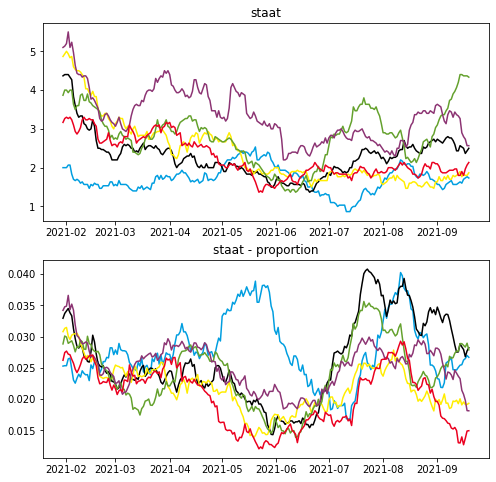

verkehr
mentioned  8064  times


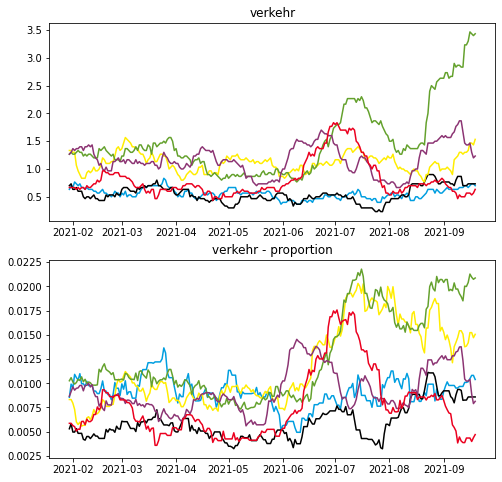

wahlen
mentioned  8064  times


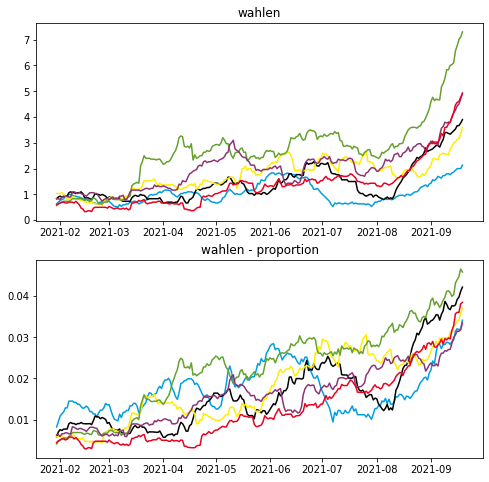

wirtschaft
mentioned  8064  times


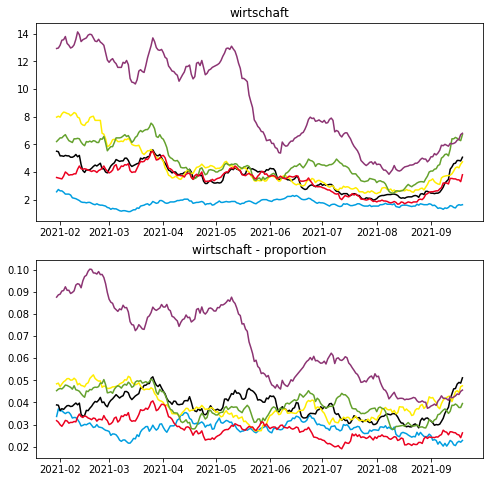

wissenschaft
mentioned  8064  times


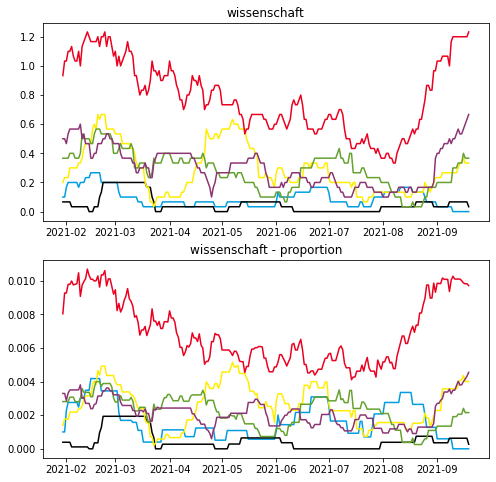

wohnen
mentioned  8064  times


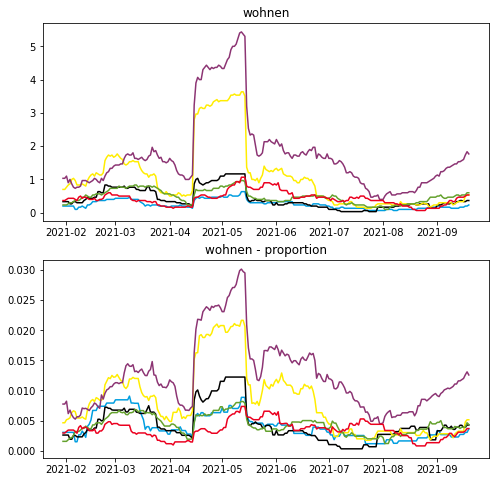

zukunft
mentioned  8064  times


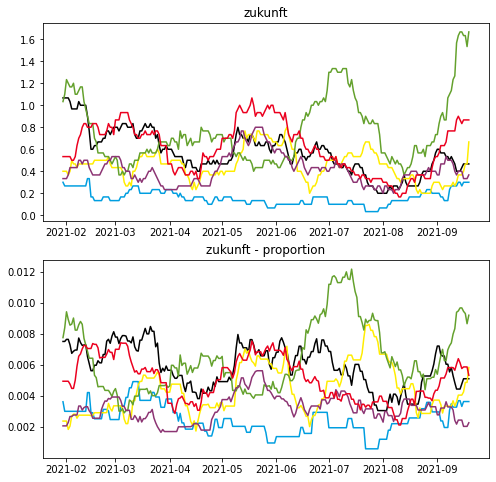

zusammenhalt
mentioned  8064  times


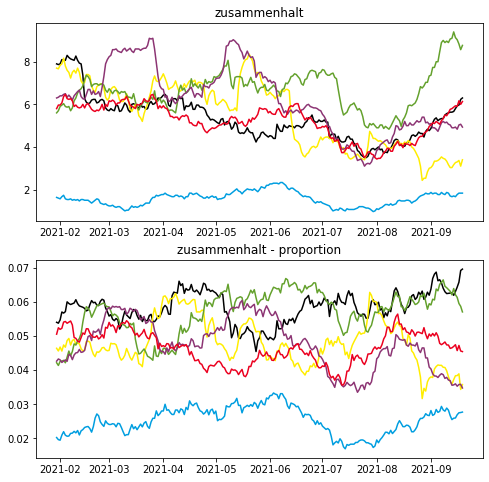

familien
mentioned  8064  times


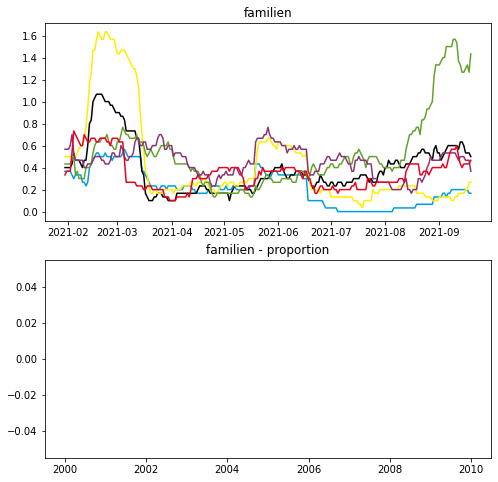

In [21]:


for j,c in enumerate(topics):
    
    print(c)
    
    sub_df = df[df[topic]==1].reset_index()
    
    print("mentioned ", sub_df.shape[0], " times")
    if not os.path.isdir(f"results/{c}"):
        os.mkdir(f"results/{c}")
        
    regex = r'\B(?!#[0-9_]+\b)(#\w{2,30})\b'
    
    vec =  CountVectorizer(min_df=1, token_pattern=regex)
    X = vec.fit_transform(sub_df.text)
    features = vec.get_feature_names()

    hashtags = pd.DataFrame()
    hashtags['hashtag'] = features

    hashtags['total'] = np.array(X.sum(axis=0)).ravel()   

    for p in df.party.unique():
        idx = sub_df[sub_df.party==p].index
        fcounts = np.array(X[idx,:].sum(axis=0)).ravel()   
        hashtags[p] = fcounts
        sorted_counts = np.argsort(fcounts)
            
    hashtags.sort_values('total',ascending=False).head(500).to_csv(f'results/{c}/top_hashtags.csv',index=False)
    
    regex = r'\b(?<!#)(\w{2,30})\b'

    vec =  CountVectorizer(min_df=1, token_pattern=regex)
    term_X = vec.fit_transform(sub_df.clean_text)
    term_features = vec.get_feature_names()

    terms = pd.DataFrame()
    terms['hashtag'] = term_features

    terms['total'] = np.array(term_X.sum(axis=0)).ravel()   

    for p in df.party.unique():
        idx = sub_df[sub_df.party==p].index
        fcounts = np.array(term_X[idx,:].sum(axis=0)).ravel()   
        terms[p] = fcounts
        sorted_counts = np.argsort(fcounts)
    
    terms.sort_values('total',ascending=False).head(500).to_csv(f'results/{c}/top_terms.csv',index=False)
    
    fig, axs = plt.subplots(2, figsize=(8,8))
    
    count_df = pd.DataFrame()

    ax = axs[0]
    for party, group in df.groupby('party'):
        counts = group.groupby(group.index.date)[c].sum()
        counts = counts.rolling(30).mean()
        count_df = count_df.merge(counts.to_frame(party),left_index=True, right_index=True,how="outer")
        ax.plot(counts, color=cdict[party.lower()])
        
    ax.set_title(c)
    
    ax = axs[1]
    for party, group in df.groupby('party'):
        counts = group.groupby(group.index.date)[c].sum() / group.groupby(group.index.date)[c].count()
        counts = counts.rolling(30).mean()
        count_df = count_df.merge(counts.to_frame(f"{party} - norm"),left_index=True, right_index=True,how="outer")
        ax.plot(counts, color=cdict[party.lower()])
        
    ax.set_title(f"{c} - proportion")
    
    plt.savefig(f"results/{c}/topic_over_time.png",bbox_inches="tight")
    count_df.to_csv(f"results/{c}/counts.csv")
    
    plt.show()


In [22]:
sub_df = df[(df['klima']==1)&(df['party']=="GRUENE") & (df.index.date>datetime.date(2021,9,1))]
sub_df.groupby(sub_df.index.date)['id'].count()

2021-09-02    10
2021-09-03     8
2021-09-04    14
2021-09-05    11
2021-09-06     4
2021-09-07    28
2021-09-08     9
2021-09-09    11
2021-09-10     9
2021-09-11     5
2021-09-12    42
2021-09-13     7
2021-09-14     5
2021-09-15     7
2021-09-16     9
2021-09-17     7
2021-09-18     5
2021-09-19    20
Name: id, dtype: int64

In [24]:
ignore_topics = [
    "politik-intern","debatte","emotion","einfamilienhaus",
    "parteien","politiker","staat","zukunft","0","?"
]

results = []
for j,c in enumerate(topics):
    if c in ignore_topics:
        continue
    topic_sum = df[c].sum()
    for party, pgroup in df.groupby('party'):
    
        results.append({
            "party":party,"topic":c,"n":pgroup[c].sum(),"topic_sum":topic_sum,
            "party_sum": pgroup.shape[0]
        })

topic_sums = pd.DataFrame.from_dict(results).sort_values('topic_sum').reset_index(drop=True)
topic_sums.to_csv('results/topic_sums.csv',index=False)
topic_sums.head()

party  topic     n  topic_sum  party_sum
0     FDP  agrar   3.0       38.0      29091
1     SPD  agrar   1.0       38.0      30496
2   LINKE  agrar   8.0       38.0      34417
3     AFD  agrar   4.0       38.0      16536
4  CDUCSU  agrar  13.0       38.0      24998

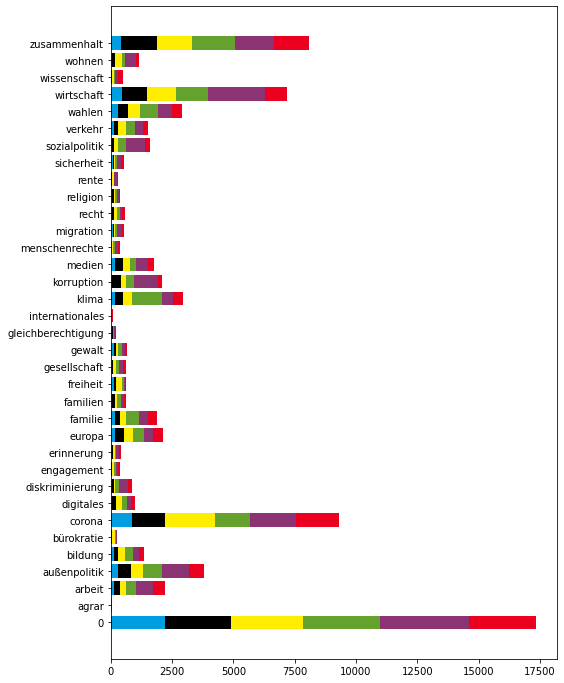

In [25]:
fig, ax = plt.subplots(figsize=(8,12))

ticks = []
for i, (name, group) in enumerate(topic_sums.groupby("topic")):
    left = 0
    for party, pgroup in group.groupby('party'):
        x = pgroup.n.values[0]
        ax.barh(i,x,color=cdict[party.lower()], left=left)
        left+=x
    ticks.append(name)
        
ax.set_yticks(range(len(ticks)))
ax.set_yticklabels(ticks)

plt.show()

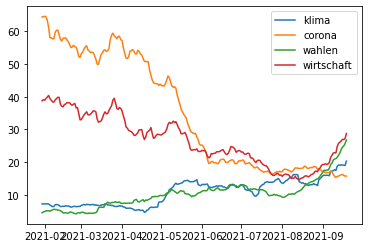

In [31]:
sub_topics = ["klima","corona","wahlen","wirtschaft"]

fig, ax = plt.subplots()

count_df = pd.DataFrame()

for c in sub_topics:
    counts = df.groupby(df.index.date)[c].sum()
    counts = counts.rolling(30).mean()
    count_df = count_df.merge(counts.to_frame(c),left_index=True, right_index=True,how="outer")
    ax.plot(counts, label=c)
    
ax.legend()

count_df.to_csv('results/comparison.csv')

plt.show()

In [27]:
group

party         topic       n  topic_sum  party_sum
192     SPD  zusammenhalt  1391.0     8064.0      30496
193   LINKE  zusammenhalt  1608.0     8064.0      34417
194  GRUENE  zusammenhalt  1747.0     8064.0      31799
195     FDP  zusammenhalt  1452.0     8064.0      29091
196  CDUCSU  zusammenhalt  1450.0     8064.0      24998
197     AFD  zusammenhalt   416.0     8064.0      16536

In [28]:
cases = pd.read_excel('data/Fallzahlen_Kum_Tab.xlsx',sheet_name="BL_7-Tage-Fallzahlen (fixiert)",skiprows=2)
cases = cases.rename(columns={"Unnamed: 0":"Land"})
cases = cases[cases["Land"]=="Gesamt"]

cases = cases[cases.columns[1:]].melt(var_name="date")

cases.head()

date  value
0 2020-05-06   5980
1 2020-05-07   5705
2 2020-05-08   5394
3 2020-05-09   5703
4 2020-05-10   5715

In [29]:
cases.columns[1:]

Index(['value'], dtype='object')

In [30]:
cases.tail()

date  value
498 2021-09-16  63444
499 2021-09-17  62095
500 2021-09-18  59846
501 2021-09-19  58610
502 2021-09-20  59052